# Analysing what transport plan corresponds to

Here I will use `pot` to calculate exact wasserstein distances and get the transport plan from there to analyze.

In [176]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot
import seaborn as sns

import sys
sys.path.append('..')
from single_cell_analysis.datasets import sciplex
from single_cell_analysis.ot import sinkhorn

import torch
from geomloss import SamplesLoss
pl.rcParams['figure.facecolor'] = 'white'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [263]:
def get_distributions(n_s, n_t):
    mu_s = np.array([0, 0])
    cov_s = np.array([[1, 0], [0, 1]])

    mu_t = np.array([4, 4])
    cov_t = np.array([[1, -.8], [-.8, 1]])

    xs = ot.datasets.make_2D_samples_gauss(n_s, mu_s, cov_s)
    xt = ot.datasets.make_2D_samples_gauss(n_t, mu_t, cov_t)
    
    # loss matrix
    M = ot.dist(xs, xt, metric='euclidean')
#     M /= M.max()
    return xs, xt, M

def get_multimodal_distributions(n_s, n_t, mu_s=None, cov_s=None, mu_t=None, cov_t=None):
    if mu_s is None:
        mu_s = [np.array([0, 0])]
        cov_s = [np.array([[1, 0], [0, 1]])]
        
        mu_t = [np.array([4, 6]),np.array([0, 8])]
        cov_t = [np.array([[1, -.8], [-.8, 1]]), np.array([[1, .8], [.8, 1]])]

    s_modals = np.random.randint(len(mu_s), size=n_s)
    t_modals = np.random.randint(len(mu_t), size=n_t)

    xs = np.zeros((n_s, 2))
    xt = np.zeros((n_t, 2))
    for i, (mu, cov) in enumerate(zip(mu_s, cov_s)):
        sample = ot.datasets.make_2D_samples_gauss(n_s, mu, cov)
        xs[s_modals == i] = sample[s_modals == i]
    for i, (mu, cov) in enumerate(zip(mu_t, cov_t)):
        sample = ot.datasets.make_2D_samples_gauss(n_t, mu, cov)
        xt[t_modals == i] = sample[t_modals == i]
    # loss matrix
    M = ot.dist(xs, xt, metric='euclidean')
#     M = ot.dist(xs, xt)
#     M /= M.max()
    return xs, xt, M

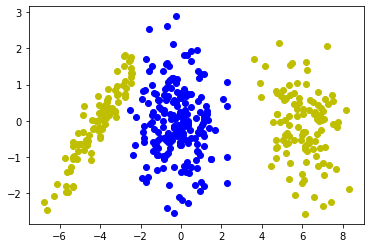

In [285]:
mu_s = [np.array([0, 0])]
cov_s = [np.array([[1, 0], [0, 1]])]

mu_t = [np.array([-4, 0]),np.array([6, 0])]
cov_t = [np.array([[1, 0.9], [0.9, 1]]), np.array([[1, 0], [0, 1]])]

xs, xt, M = get_multimodal_distributions(200,200, mu_s=mu_s, cov_s=cov_s, mu_t=mu_t, cov_t=cov_t)

pl.scatter(xs[:,0], xs[:,1], c='b')
pl.scatter(xt[:,0], xt[:,1], c='y')

In [6]:
np.random.randint(2, size=(3,3))

array([[1, 1, 1],
       [0, 0, 1],
       [1, 1, 1]])

## Monge formulation (equal number of points)

### Generate data

Let's create two distributions with same number of points first:

In [91]:
n_source = 10
n_target = 10
source, target, cost_matrix = get_distributions(n_source, n_target)

Now let's plot what we have:

In [92]:
cost_matrix

array([[ 6.11411061,  5.79343336,  6.31443836,  5.85250501,  4.96740899,
         7.17666456,  7.9625929 ,  6.18750394,  5.15052579,  6.29019095],
       [ 6.03173841,  5.71106117,  6.23206616,  5.77013282,  4.88503679,
         7.09429237,  7.88022071,  6.10513175,  5.06815359,  6.20781876],
       [ 5.92861401,  5.60793676,  6.12894176,  5.66700841,  4.78191239,
         6.99116796,  7.7770963 ,  6.00200734,  4.96502919,  6.10469435],
       [ 8.6831687 ,  8.36249146,  8.88349646,  8.42156311,  7.53646709,
         9.74572266, 10.531651  ,  8.75656204,  7.71958389,  8.85924905],
       [ 7.74429055,  7.42361331,  7.94461831,  7.48268496,  6.59758894,
         8.80684451,  9.59277285,  7.81768389,  6.78070574,  7.9203709 ],
       [ 7.92070332,  7.60002608,  8.12103107,  7.65909772,  6.7740017 ,
         8.98325727,  9.76918561,  7.99409666,  6.9571185 ,  8.09678367],
       [ 8.16835692,  7.84767967,  8.36868467,  7.90675132,  7.0216553 ,
         9.23091087, 10.01683921,  8.24175025

Text(0.5, 1.0, 'Cost matrix C')

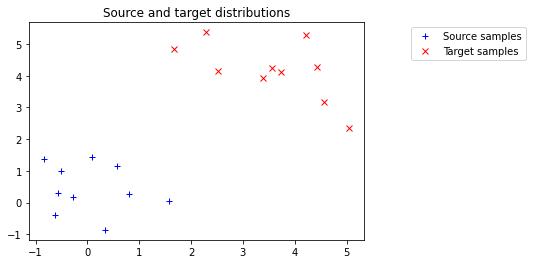

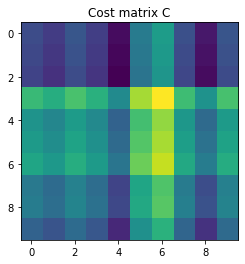

In [93]:
pl.figure(1)
pl.plot(source[:, 0], source[:, 1], '+b', label='Source samples')
pl.plot(target[:, 0], target[:, 1], 'xr', label='Target samples')
pl.legend(bbox_to_anchor=(1.5,1))
pl.title('Source and target distributions')

pl.figure(2)
pl.imshow(cost_matrix, interpolation='nearest')
pl.title('Cost matrix C')

### Calculate optimal transport matrix

In [94]:
a, b = np.ones((n_source,)) / n_source, np.ones((n_target,)) / n_target  # uniform distribution on samples
transport_plan = ot.emd(a, b, cost_matrix)

We found the transport plan matrix. Let's investigate it's properties:

In [95]:
print(f'Total sum: {transport_plan.sum()}')
print(f'Sum per row: {transport_plan.sum(axis=1)}')
print(f'Sum per column: {transport_plan.sum(axis=0)}')

Total sum: 1.0
Sum per row: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Sum per column: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


Sum over columns for each row has the same value `0.1`. It's the same for sum over rows for each column. Nothing special here.

Now let's look into values in a specific row (transport plan for a particular point in source distribution):

In [96]:
print(f'Transport plan for source point index 0:\n {transport_plan[0,:]}')

Transport plan for source point index 0:
 [0.  0.  0.  0.  0.  0.  0.  0.1 0.  0. ]


Here we see that the only one of the elements has non-zero value, which means there is a coupling only for that specific point form the target distribution.

Now we can visualize the full matrix to see the same behavior:

In [105]:
cost_matrix.min()

4.7819123881128895

<AxesSubplot:>

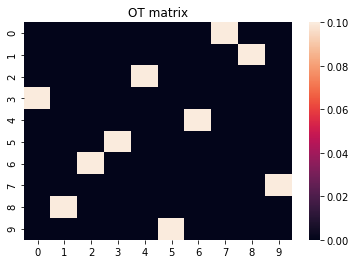

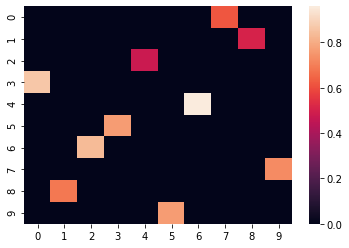

In [98]:
pl.figure(3)
sns.heatmap(transport_plan)
pl.title('OT matrix')
pl.figure()
sns.heatmap(transport_plan * cost_matrix)

And now, let's draw couplings as lines in the scatter plot:

Text(0.5, 1.0, 'OT matrix with samples')

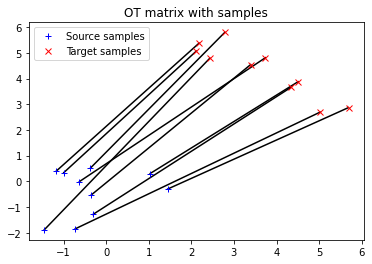

In [13]:
pl.figure(4)
ot.plot.plot2D_samples_mat(source, target, transport_plan)
pl.plot(source[:, 0], source[:, 1], '+b', label='Source samples')
pl.plot(target[:, 0], target[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('OT matrix with samples')

We directly observe the one-to-one coupling, which corresponds to the Monge formulation.

### transport_plan.dot(transport_plan.T) analysis

This operation gives back to us a matrix where non-zero values indicates if there is a path between two points in the same distribution in the bipartite graph above.

For equal distribution sizes, there will always be a one-to-one mapping, so only diagonal values would have non-zero values.

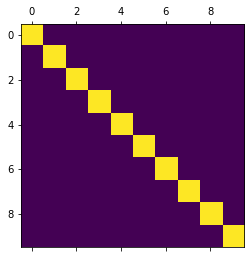

In [14]:
pl.matshow(transport_plan @ transport_plan.T)

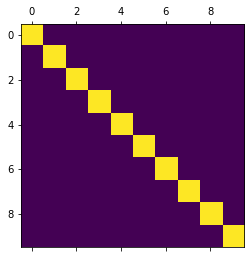

In [15]:
pl.matshow(transport_plan.T @ transport_plan)

## Kantorovich relaxation (different number of points)

### Generate data

In [16]:
n_source = 3
n_target = 10
source, target, cost_matrix = get_distributions(n_source, n_target)

Text(0.5, 1.0, 'Cost matrix C')

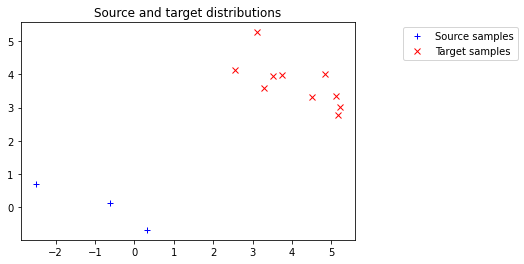

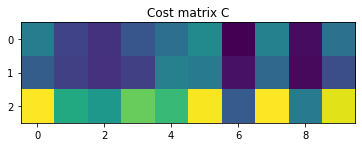

In [17]:
pl.figure(1)
pl.plot(source[:, 0], source[:, 1], '+b', label='Source samples')
pl.plot(target[:, 0], target[:, 1], 'xr', label='Target samples')
pl.legend(bbox_to_anchor=(1.5,1))
pl.title('Source and target distributions')

pl.figure(2)
pl.imshow(cost_matrix, interpolation='nearest')
pl.title('Cost matrix C')

### Calculate transport plan matrix

In [18]:
a, b = np.ones((n_source,)) / n_source, np.ones((n_target,)) / n_target  # uniform distribution on samples
transport_plan = ot.emd(a, b, cost_matrix)

In [19]:
print(f'Total sum: {transport_plan.sum()}')
print(f'Sum per row: {transport_plan.sum(axis=1)}')
print(f'Sum per column: {transport_plan.sum(axis=0)}')

Total sum: 0.9999999999999999
Sum per row: [0.33333333 0.33333333 0.33333333]
Sum per column: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


Again, the sums are just the same values, representing a uniform distribution of weights over elements.

In [20]:
print(f'Transport plan for source point index 0:\n {transport_plan[0,:]}')

Transport plan for source point index 0:
 [0.         0.1        0.06666667 0.06666667 0.         0.1
 0.         0.         0.         0.        ]


In [21]:
print(f'Transport plan for target point index 1:\n {transport_plan[:,1]}')

Transport plan for target point index 1:
 [0.1 0.  0. ]


Text(0.5, 1.0, 'OT matrix')

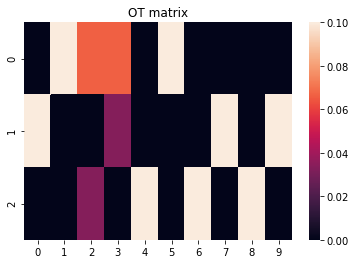

In [22]:
pl.figure(3)
sns.heatmap(transport_plan)
pl.title('OT matrix')

Text(0.5, 1.0, 'OT matrix with samples')

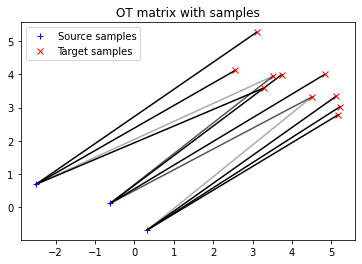

In [23]:
pl.figure(4)
ot.plot.plot2D_samples_mat(source, target, transport_plan)
pl.plot(source[:, 0], source[:, 1], '+b', label='Source samples')
pl.plot(target[:, 0], target[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('OT matrix with samples')

In this case, a point in source sample needs to be coupled with multiple points to have a full transport plan for each point in the target distribution. This creates a different bipartite graph where edge weights might be different across edges this time. This means we can get a more interesting diagonalization of transport plan:

### transport_plan.dot(transport_plan.T) analysis

<AxesSubplot:>

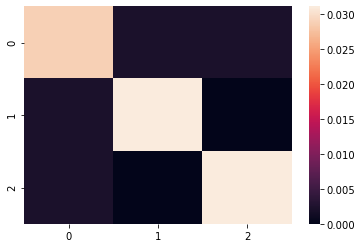

In [24]:
sns.heatmap(transport_plan @ transport_plan.T)

<AxesSubplot:>

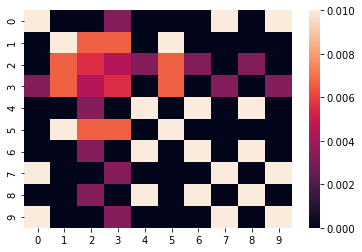

In [25]:
sns.heatmap(transport_plan.T @ transport_plan)

### PCA Analysis for transport plan and variations

Let's do a PCA analysis and plot latent embeddings for `transport_plan` and `transport_plan.T`:

In [26]:
from sklearn.decomposition import PCA

In [27]:
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(transport_plan)
pca = PCA(n_components=2)
pca_fit_transpose = pca.fit_transform(transport_plan.T)

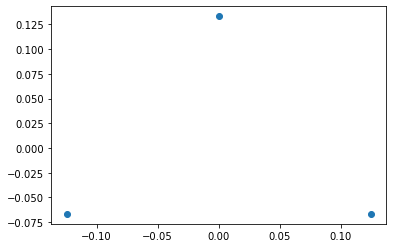

In [28]:
pl.scatter(pca_fit[:,0], pca_fit[:,1])

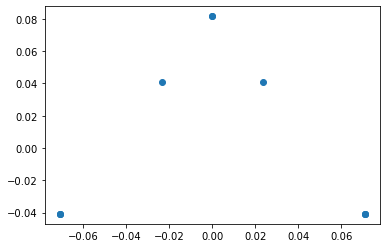

In [29]:
pl.scatter(pca_fit_transpose[:,0], pca_fit_transpose[:,1])

Using this latent space gives us a way to measure the similarities of the transport plans for each point. For example, in the second plot, we see 5 points event though there are 10 points in total because there are duplicate latent values:

<AxesSubplot:>

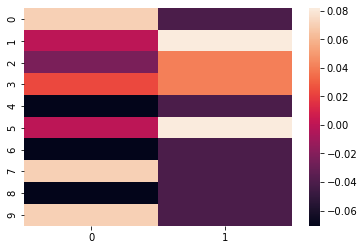

In [30]:
sns.heatmap(pca_fit_transpose)

For example, indices 1 and 5 has the same PCA embedding, which mean they are coupled with the exact same set of points from the source distribution.

In [31]:
n_source = 10
n_target = 10
source, target, cost_matrix = get_distributions(n_source, n_target)

a, b = np.ones((n_source,)) / n_source, np.ones((n_target,)) / n_target  # uniform distribution on samples
transport_plan = ot.emd(a, b, cost_matrix)
distance = ot.emd2(a, b, cost_matrix)

In [32]:
np.sum(transport_plan * cost_matrix)

0.6099733261149349

In [33]:
distance

0.6099733261149349

In [34]:
(transport_plan * cost_matrix).sum()

0.6099733261149349

In [35]:
(transport_plan * cost_matrix).sum(axis=0)

array([0.06838595, 0.07602103, 0.05555631, 0.06631065, 0.0773847 ,
       0.05328141, 0.05841553, 0.05643973, 0.04782599, 0.05035204])

In [36]:
(transport_plan * cost_matrix).sum(axis=1)

array([0.05643973, 0.05328141, 0.05035204, 0.0773847 , 0.06631065,
       0.05555631, 0.05841553, 0.07602103, 0.04782599, 0.06838595])

<AxesSubplot:>

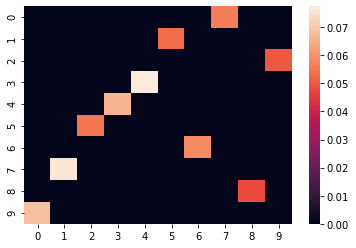

In [37]:
sns.heatmap(transport_plan * cost_matrix)

<AxesSubplot:>

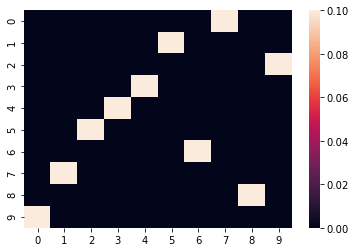

In [38]:
sns.heatmap(transport_plan)

In [39]:
a[[0]].shape

(1,)

In [40]:
cost_matrix.shape

(10, 10)

In [41]:
source, target, cost_matrix = get_distributions(1, 10)
a, b = np.ones((1,)) / 1, np.ones((10,)) / 10  # uniform distribution on samples

In [42]:
transport_plan = ot.emd(a, b, cost_matrix)

In [43]:
transport_plan

array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]])

In [296]:
def plot_transport_cost_per_cell(n_s=None, n_t=None, s=None, t=None, base_metric='euclidian', lines_per_cell_pair=True):
    if s is None:
        s, t, C = get_multimodal_distributions(n_s, n_t)
    else:
        n_s = len(s)
        n_t = len(t)
    C = ot.dist(s, t, metric=base_metric)
    a, b = np.ones((n_s,)) / n_s, np.ones((n_t,)) / n_t  # uniform distribution on samples
    T = ot.emd(a, b, C)
    distance = ot.emd2(a, b, C)
    device = torch.device('cpu')
    sink = sinkhorn.SinkhornDistance(eps=0.1, max_iter=100)
    sink_result = sink(torch.from_numpy(s),torch.from_numpy(t))
    print(sink_result[0])
    print(distance)
    W = T * C
    
    idx_W_max = np.unravel_index(np.argmax(W), W.shape)
    W_tmp = W.copy()
    W_tmp[W_tmp == 0] = 1
    idx_W_min = np.unravel_index(np.argmin(W_tmp), W.shape)
    
    pl.figure(1)
    if lines_per_cell_pair:
        ot.plot.plot2D_samples_mat(s, t, W, c=[.5, .5, 1])
    s_cost = W.sum(axis=1)
    t_cost = W.sum(axis=0)
    
    sns.scatterplot(x=s[:, 0], y=s[:, 1], hue=s_cost, palette='summer', label='Source samples')
    sns.scatterplot(x=t[:, 0], y=t[:, 1], hue=t_cost, palette='autumn', label='Target samples')
    
    pl.plot([s[idx_W_max[0]][0], t[idx_W_max[1]][0]], [s[idx_W_max[0]][1], t[idx_W_max[1]][1]], '-', color='black', label=f'Max coupling: {W[idx_W_max[0], idx_W_max[1]]}')
    pl.plot([s[idx_W_min[0]][0], t[idx_W_min[1]][0]], [s[idx_W_min[0]][1], t[idx_W_min[1]][1]], '--', color='black', label=f'Min coupling: {W[idx_W_min[0], idx_W_min[1]]}')

    pl.legend(bbox_to_anchor=(1.5,1))
    pl.title('Source and target distributions')


In [362]:
import umap

def plot_transport_cost_per_cell(n_s=None, n_t=None, s=None, t=None, base_metric='euclidian', lines_per_cell_pair=True, plot_others=False):
    if s is None:
        s, t, C = get_multimodal_distributions(n_s, n_t)
    else:
        n_s = len(s)
        n_t = len(t)
    C = ot.dist(s, t, metric=base_metric)
    a, b = np.ones((n_s,)) / n_s, np.ones((n_t,)) / n_t  # uniform distribution on samples
    T = ot.emd(a, b, C)
    distance = ot.emd2(a, b, C)
    device = torch.device('cpu')
    sink = sinkhorn.SinkhornDistance(eps=0.1, max_iter=100)
    sink_result = sink(torch.from_numpy(s),torch.from_numpy(t))
    print(sink_result[0])
    print(distance)
    W = T * C
    
    idx_W_max = np.unravel_index(np.argmax(W), W.shape)
    W_tmp = W.copy()
    W_tmp[W_tmp == 0] = 1
    idx_W_min = np.unravel_index(np.argmin(W_tmp), W.shape)
    
    pl.figure(1)
    if lines_per_cell_pair:
        ot.plot.plot2D_samples_mat(s, t, W, c=[.5, .5, 1])
    s_cost = W.sum(axis=1)
    t_cost = W.sum(axis=0)
    
    sns.scatterplot(x=s[:, 0], y=s[:, 1], hue=s_cost, palette='summer', label='Source samples')
    sns.scatterplot(x=t[:, 0], y=t[:, 1], hue=t_cost, palette='autumn', label='Target samples')
    
    pl.plot([s[idx_W_max[0]][0], t[idx_W_max[1]][0]], [s[idx_W_max[0]][1], t[idx_W_max[1]][1]], '-', color='black', label=f'Max coupling: {W[idx_W_max[0], idx_W_max[1]]}')
    pl.plot([s[idx_W_min[0]][0], t[idx_W_min[1]][0]], [s[idx_W_min[0]][1], t[idx_W_min[1]][1]], '--', color='black', label=f'Min coupling: {W[idx_W_min[0], idx_W_min[1]]}')

    pl.legend(bbox_to_anchor=(1.5,1))
    pl.title('Source and target distributions')

    if not plot_others:
        return W, T, C
    
    pl.figure(2)
    pl.imshow(C, interpolation='nearest')
    pl.title('Cost matrix C')

    pl.figure()
    sns.heatmap(T)
    pl.title('Transport Plan T')
    pl.figure()
    sns.heatmap(W)
    pl.title('Wasserstein matrix W')
    
    pl.figure()
    sns.heatmap(W.T @ W)    
    pl.title('W.T @ W')

    pl.figure()
    sns.heatmap(W @ W.T)
    pl.title('W @ W.T')

    drs = {
        "PCA" : PCA(n_components=2),
        'UMAP' : umap.UMAP()
    }
    matrices = {
        'W' : W, 
        'W @ W.T' : W @ W.T,
        'W.T @ W' : W.T @ W
    }
    
    for k_dr, v_dr in drs.items():
        for k_m, v_m in matrices.items():
            fit = v_dr.fit_transform(v_m)
            fit_transpose = v_dr.fit_transform(v_m.T)
    #         pl.figure()
    #         pl.matshow(fit)
    #         pl.title(f'2D {k} matrix of Source samples')
    #         pl.figure()
    #         pl.matshow(fit_transpose)
    #         pl.title(f'2D {k} matrix of Target samples')
            print(v_m.shape)
            print(fit.shape)
            pl.figure()
            pl.scatter(fit[:,0], fit[:,1])
            pl.title(f'2D {k_dr} of {k_m}')
            print(v_m.T.shape)
            print(fit_transpose.shape)
            pl.figure()
            pl.scatter(fit_transpose[:,0], fit_transpose[:,1])
            pl.title(f'2D {k_dr} of {k_m} transpose')
            
    umap_ = umap.UMAP(metric='precomputed')
    fit = umap_.fit_transform( 1 - W @ W.T)
    pl.figure()
    pl.scatter(fit[:,0], fit[:,1])
    pl.title(f'2D UMAP with 1 - W @ W.T as distance matrix')
    
    
    
    return W, T, C

In [135]:
result[0].shape

(500, 500)

In [137]:
sns.lineplot()

(268, 398)

tensor(9.0338, dtype=torch.float64)
7.437508038692314
(500, 200)
(500, 2)
(200, 500)
(200, 2)
(500, 500)
(500, 2)
(500, 500)
(500, 2)
(200, 200)
(200, 2)
(200, 200)
(200, 2)
(500, 200)
(500, 2)
(200, 500)
(200, 2)
(500, 500)
(500, 2)
(500, 500)
(500, 2)
(200, 200)
(200, 2)
(200, 200)
(200, 2)


/home/yavuz/miniconda3/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


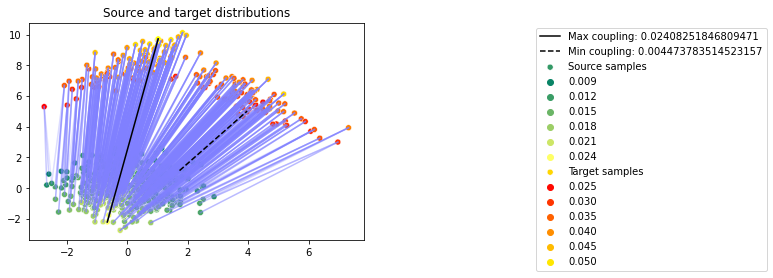

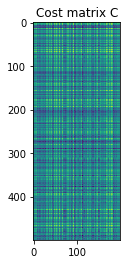

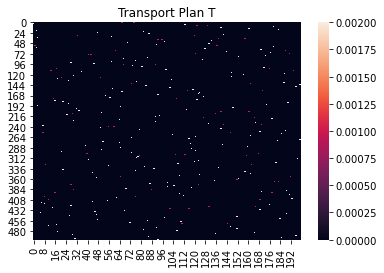

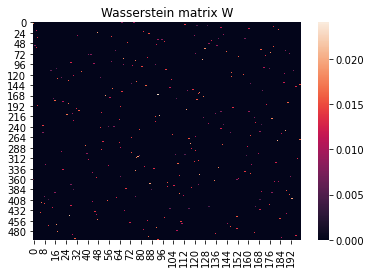

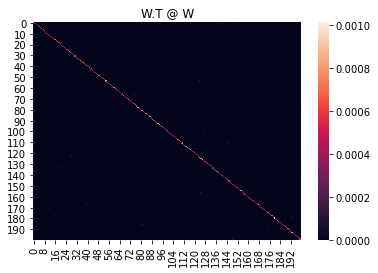

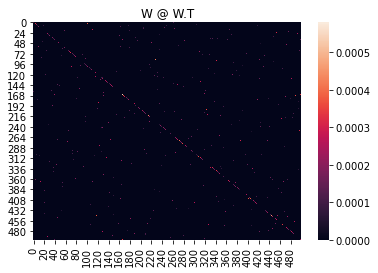

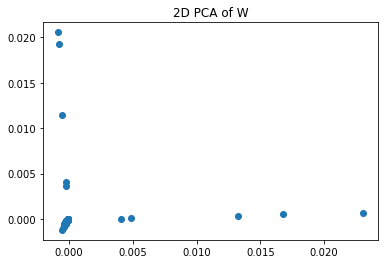

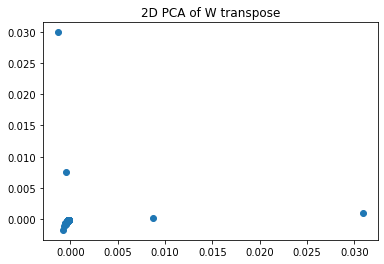

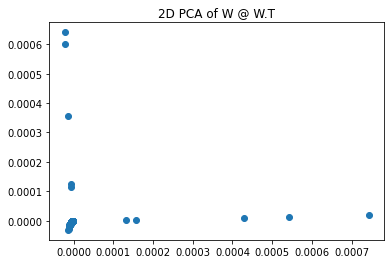

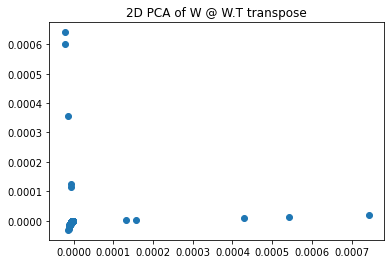

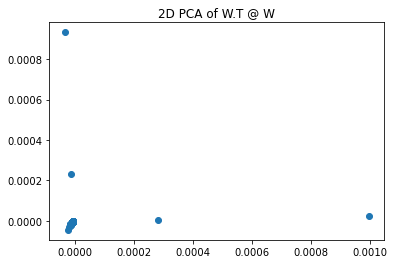

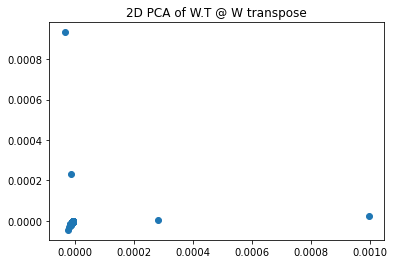

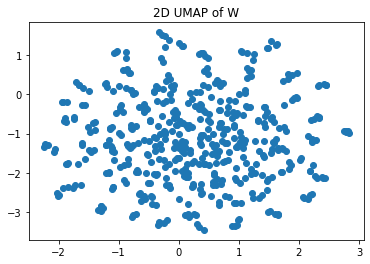

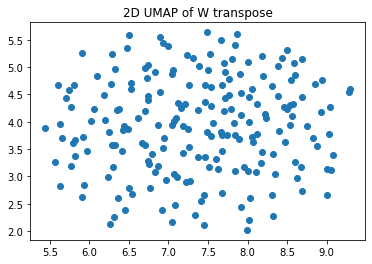

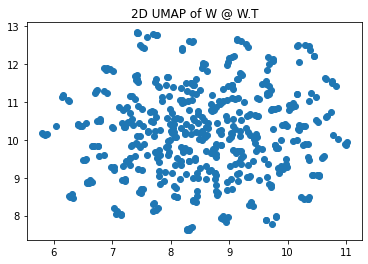

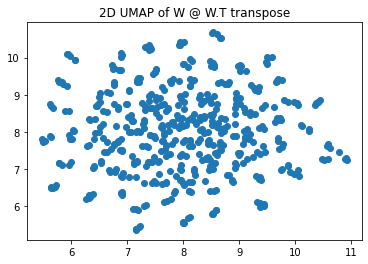

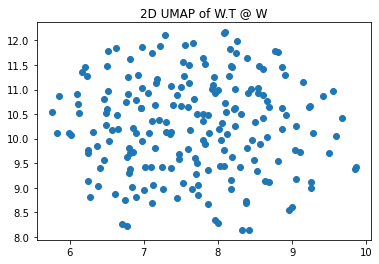

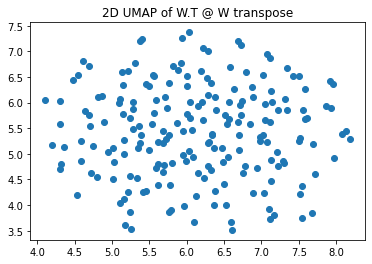

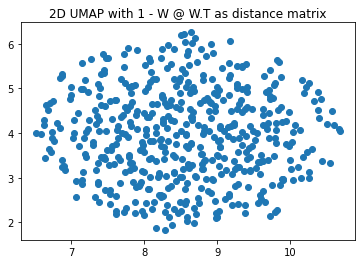

In [218]:
result = run(500,200)

In [ ]:
result[2].sum()

In [ ]:
result[0].sum()

In [ ]:
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(W)
pca = PCA(n_components=2)
pca_fit_transpose = pca.fit_transform(W.T)

In [ ]:
pl.scatter(pca_fit[:,0], pca_fit[:,1])

In [ ]:
sns.heatmap(pca_fit)

In [ ]:
sns.heatmap(pca_fit_transpose)

In [ ]:
pca_fit_transpose.shape

In [ ]:
pca_fit_transpose[np.argwhere(pca_fit_transpose > 0.0001)[:,0]].shape

In [ ]:
idx = np.argwhere(pca_fit_transpose > 0.0001)
pl.scatter(pca_fit_transpose[idx[:,0],0], pca_fit_transpose[idx[:,0],1])

In [106]:
device = torch.device('cpu')
def test_equality(n_s,n_t):
    mu_s = np.array([0, 0])
    cov_s = np.array([[1, 0], [0, 1]])

    mu_t1 = np.array([4, 6])
    cov_t1 = np.array([[1, -.8], [-.8, 1]])

    mu_t2 = np.array([0, 8])
    cov_t2 = np.array([[1, .8], [.8, 1]])

    selected_modal = np.random.randint(2, size=n_t)
    xs = ot.datasets.make_2D_samples_gauss(n_s, mu_s, cov_s)

    xt1 = ot.datasets.make_2D_samples_gauss(n_t, mu_t1, cov_t1)
    xt2 = ot.datasets.make_2D_samples_gauss(n_t, mu_t2, cov_t2)

    xt = xt1
    xt[selected_modal > 0] = xt2[selected_modal > 0]
    geomloss = SamplesLoss(loss="sinkhorn", scaling=0.9, p=1, debias=True).to(device)
    cuturi = sinkhorn.SinkhornDistance(eps=0.1, max_iter=100).to(device)
    cuturi_result = cuturi(torch.from_numpy(xs), torch.from_numpy(xt))
    geomloss_result = geomloss(torch.from_numpy(xs), torch.from_numpy(xt))
    print(cuturi_result[0])
    print(geomloss_result)
    
    
    C = ot.dist(xs, xt, metric='cityblock')
    a, b = np.ones((n_s,)) / n_s, np.ones((n_t,)) / n_t  # uniform distribution on samples
    print(ot.emd2(a, b, C))
    
    C = ot.dist(xs, xt)
    a, b = np.ones((n_s,)) / n_s, np.ones((n_t,)) / n_t  # uniform distribution on samples
    print(ot.emd2(a, b, C))

In [107]:
test_equality(1000,1000)

tensor(8.9426, dtype=torch.float64)
tensor(7.2002, dtype=torch.float64)
8.937355795891852
55.721823048678935


# Effect of base cost metric on transport cost per point

Wasserstein distance calculates the optimal transport plan according to a point-wise base metric. Standard popular ones are manhatten distance (L1 norm) and euclidean distance (L2 norm) along with others.

Let's observe the effect of the base metric on calculated transport plan and point wise transport cost coloring:

### Euclidean (L-2 norm)

tensor(9.0003, dtype=torch.float64)
7.295128909077425


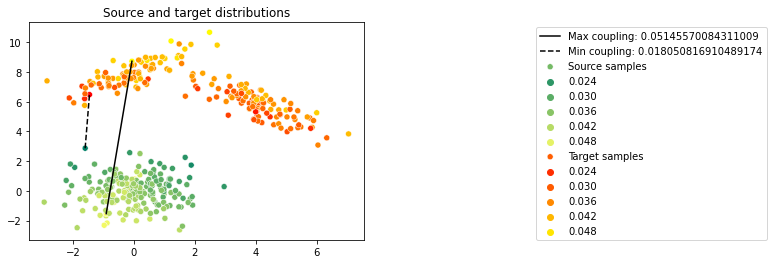

In [232]:
plot_transport_cost_per_cell(200, 200, base_metric='euclidean', lines_per_cell_pair=False)

### Manhattan (L-1 norm)

tensor(8.8970, dtype=torch.float64)
8.891371679916933


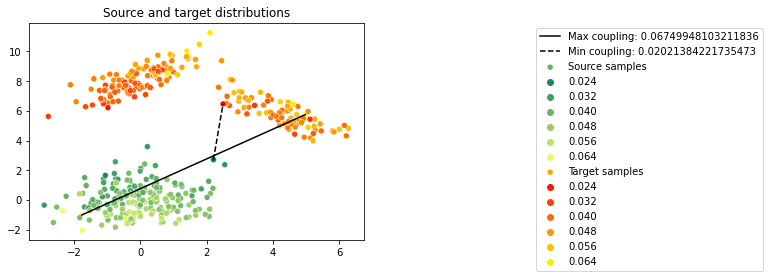

In [237]:
plot_transport_cost_per_cell(200, 200, base_metric='cityblock', lines_per_cell_pair=False)

### Squared Euclidean (L-2 norm squared)

tensor(9.1856, dtype=torch.float64)
59.18665790305403


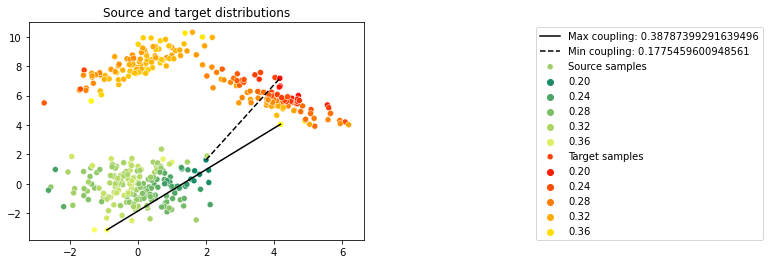

In [290]:
plot_transport_cost_per_cell(200, 200, base_metric='sqeuclidean', lines_per_cell_pair=False)

tensor(3.4413, dtype=torch.float64)
3.27323973183786


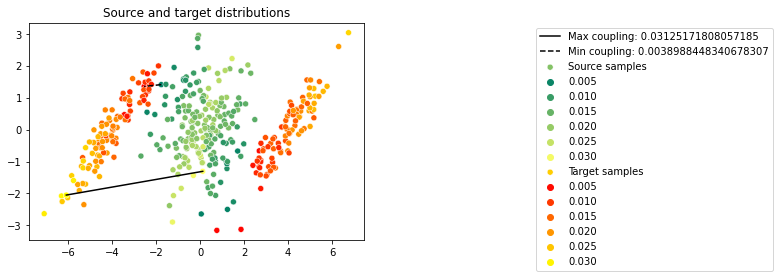

In [308]:
mu_s = [np.array([0, 0])]
cov_s = [np.array([[1, 0], [0, 1]])]

mu_t = [np.array([-4, 0]),np.array([4, 0])]
# cov_t = [np.array([[1, 0.9], [0.9, 1]]), np.array([[1, -0.9], [-0.9, 1]])]
cov_t = [np.array([[1, 0.9], [0.9, 1]]), np.array([[1, 0.9], [0.9, 1]])]

xs, xt, M = get_multimodal_distributions(200,200, mu_s=mu_s, cov_s=cov_s, mu_t=mu_t, cov_t=cov_t)

# pl.scatter(xs[:,0], xs[:,1], c='b')
# pl.scatter(xt[:,0], xt[:,1], c='y')
plot_transport_cost_per_cell(s=xs, t=xt, base_metric='euclidean', lines_per_cell_pair=False)

tensor(3.3419, dtype=torch.float64)
3.1749676253625565


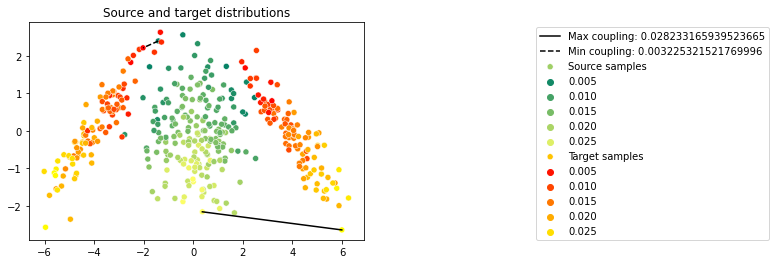

In [309]:
mu_s = [np.array([0, 0])]
cov_s = [np.array([[1, 0], [0, 1]])]

mu_t = [np.array([-4, 0]),np.array([4, 0])]
cov_t = [np.array([[1, 0.9], [0.9, 1]]), np.array([[1, -0.9], [-0.9, 1]])]
# cov_t = [np.array([[1, 0.9], [0.9, 1]]), np.array([[1, 0.9], [0.9, 1]])]

xs, xt, M = get_multimodal_distributions(200,200, mu_s=mu_s, cov_s=cov_s, mu_t=mu_t, cov_t=cov_t)

# pl.scatter(xs[:,0], xs[:,1], c='b')
# pl.scatter(xt[:,0], xt[:,1], c='y')
plot_transport_cost_per_cell(s=xs, t=xt, base_metric='euclidean', lines_per_cell_pair=False)

# Sciplex

In [316]:
from pathlib import Path
import scanpy as sc

data_path = Path('/home/yavuz/data/sciplex')
figures_path = Path('figures')
figures_path.mkdir(exist_ok=True)

sciplex2 = sciplex.SciPlex2(data_path / 'sciplex2', preprocess=True).dataset

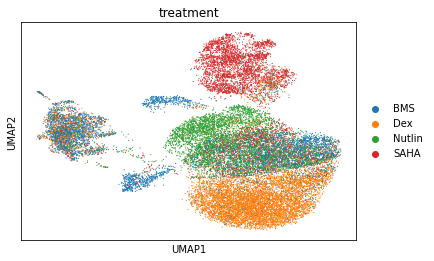

In [356]:
sc.pl.umap(sciplex2, color='treatment')

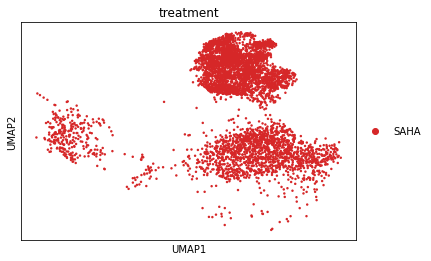

In [357]:
sc.pl.umap(sciplex2[sciplex2.obs['treatment'] == 'SAHA'], color='treatment')

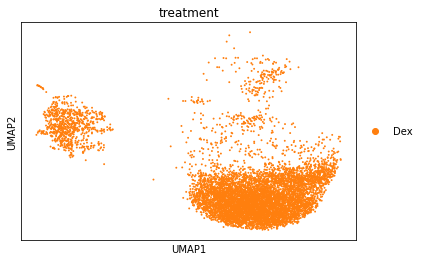

In [358]:
sc.pl.umap(sciplex2[sciplex2.obs['treatment'] == 'Dex'], color='treatment')

In [326]:
sciplex2.obsm['X_pca'].shape

(24189, 100)

In [338]:
s = sciplex2[(sciplex2.obs['treatment'] == 'SAHA') & (sciplex2.obs['dose'] == 10.0)].obsm['X_pca']
t = sciplex2[(sciplex2.obs['treatment'] == 'Dex') & (sciplex2.obs['dose'] == 10.0)].obsm['X_pca']

/home/yavuz/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/yavuz/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


tensor(143.1976)
28.650223017498753


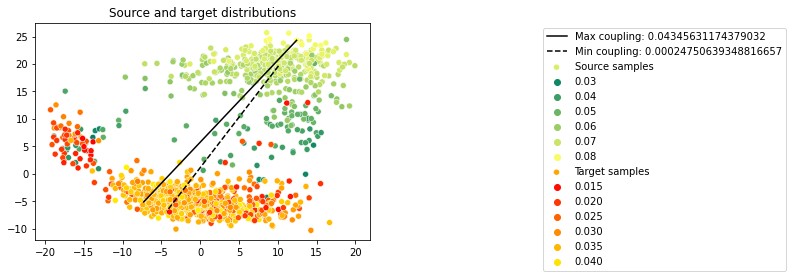

In [341]:
plot_transport_cost_per_cell(s=s, t=t, base_metric='euclidean', lines_per_cell_pair=False)

tensor(143.1976)
28.650223017498753


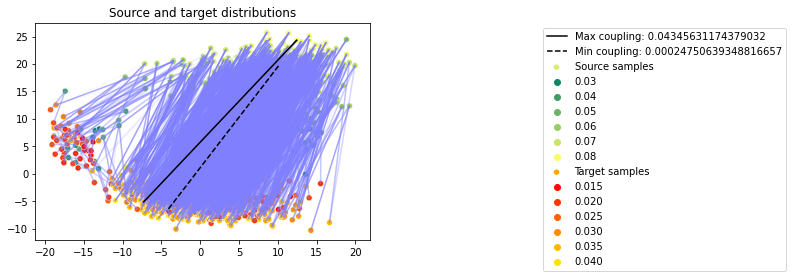

In [348]:
plot_transport_cost_per_cell(s=s, t=t, base_metric='euclidean', lines_per_cell_pair=True)

tensor(29.2008)
23.01784761061113


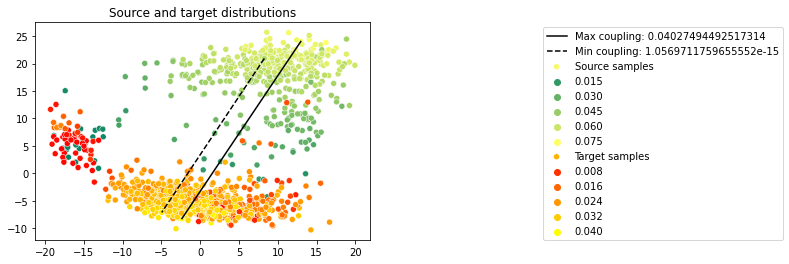

In [345]:
plot_transport_cost_per_cell(s=s[:,:2], t=t[:,:2], base_metric='euclidean', lines_per_cell_pair=False)

tensor(30.4271)
23.459382644133836


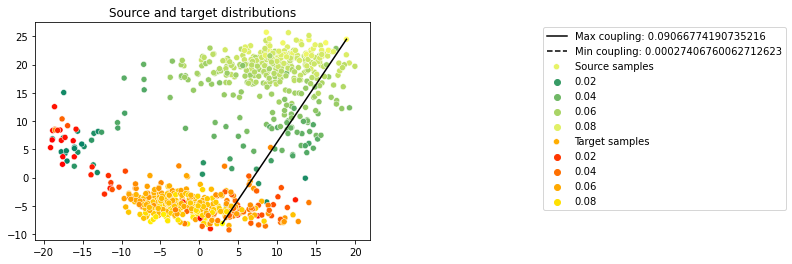

In [347]:
plot_transport_cost_per_cell(s=s[:400,:2], t=t[:400,:2], base_metric='euclidean', lines_per_cell_pair=False)

tensor(143.1976)
28.650223017498753
(459, 888)
(459, 2)
(888, 459)
(888, 2)
(459, 459)
(459, 2)
(459, 459)
(459, 2)
(888, 888)
(888, 2)
(888, 888)
(888, 2)
(459, 888)
(459, 2)
(888, 459)
(888, 2)
(459, 459)
(459, 2)
(459, 459)
(459, 2)
(888, 888)
(888, 2)
(888, 888)
(888, 2)


/home/yavuz/miniconda3/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[35.91094465, 34.64439067, 33.41840616, ..., 35.88690713,
         36.68408895, 36.20163548],
        [25.48662705, 27.43324554, 20.90853151, ..., 21.81835049,
         25.92725471, 23.41741588],
        [39.13893684, 38.97146533, 36.04074764, ..., 40.04604912,
         37.90698125, 40.78746438],
        ...,
        [35.31555988, 34.15824857, 33.93186039, ..., 33.78912333,
         36.10110498, 34.73779338],
        [31.29455472, 34.15055136, 29.27888176, ..., 31.66561403,
         33.039

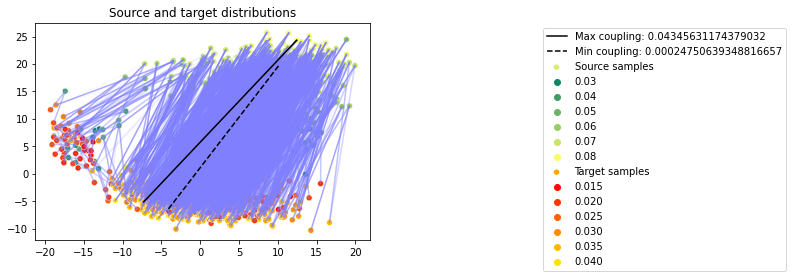

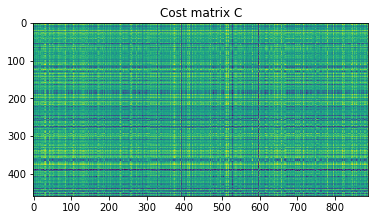

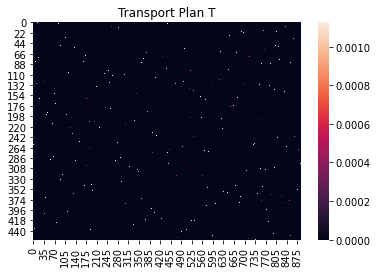

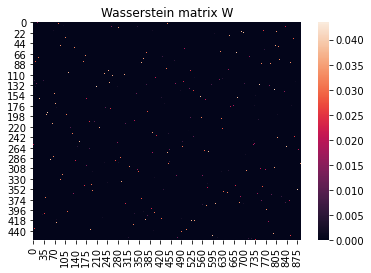

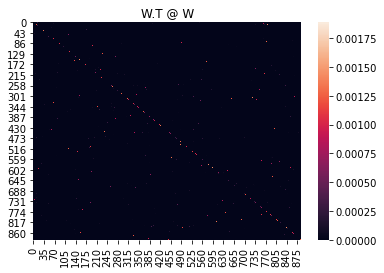

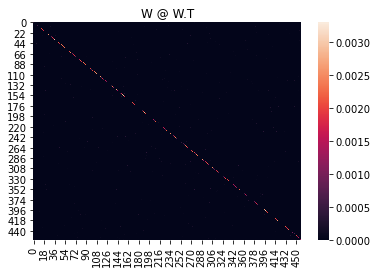

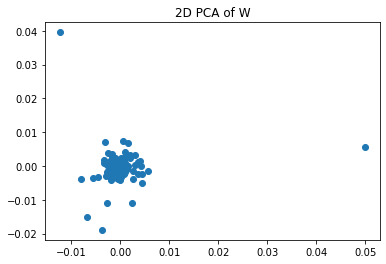

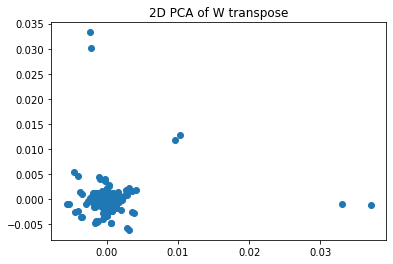

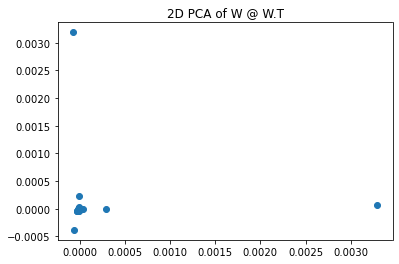

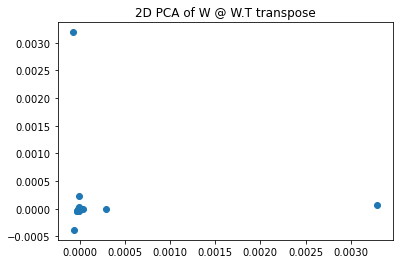

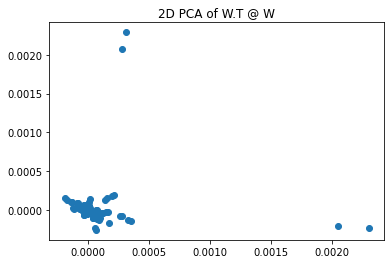

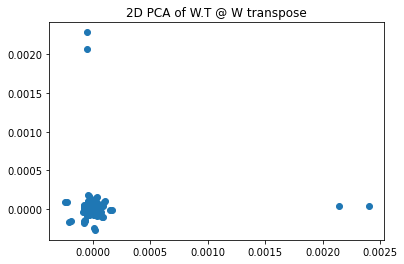

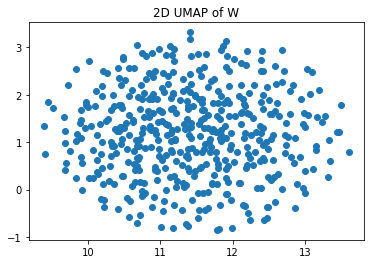

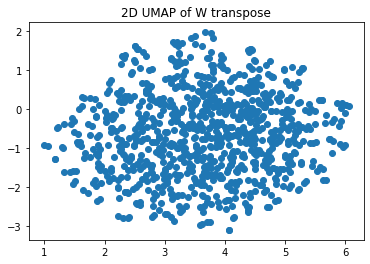

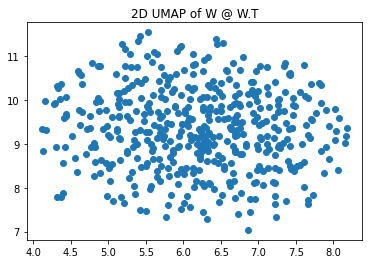

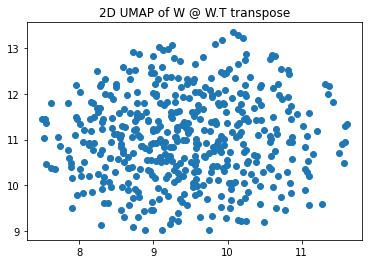

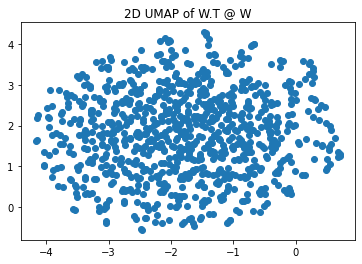

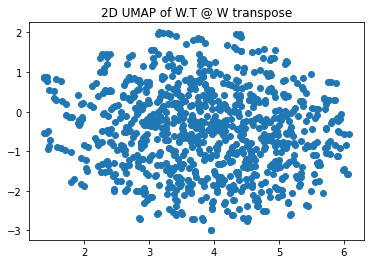

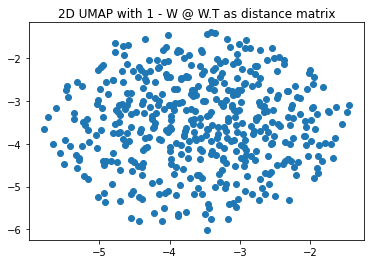

In [353]:
plot_transport_cost_per_cell(s=s, t=t, base_metric='euclidean', lines_per_cell_pair=True, plot_others=True)

# Differential gene expression analysis

/home/yavuz/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/yavuz/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


tensor(143.1976)
28.650223017498753


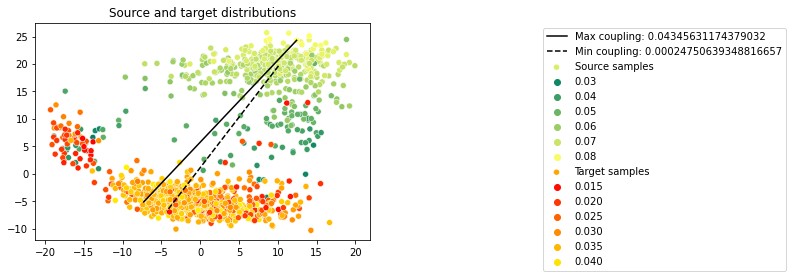

In [363]:
s = sciplex2[(sciplex2.obs['treatment'] == 'SAHA') & (sciplex2.obs['dose'] == 10.0)].obsm['X_pca']
t = sciplex2[(sciplex2.obs['treatment'] == 'Dex') & (sciplex2.obs['dose'] == 10.0)].obsm['X_pca']
saha10_vs_dex10 = plot_transport_cost_per_cell(s=s, t=t, base_metric='euclidean', lines_per_cell_pair=False)

In [391]:
np.count_nonzero(sciplex2.obs.index.isin(saha_sorted_index))

459

In [397]:
saha_sorted_index

Index(['G08_B02_RT_606', 'G09_A01_RT_635', 'C07_B02_RT_424', 'G05_A01_RT_710',
       'E07_A01_RT_449', 'C04_B02_RT_509', 'B08_B02_RT_476', 'F09_A01_RT_617',
       'G12_A01_RT_619', 'D04_A01_RT_425',
       ...
       'C01_A01_RT_466', 'G01_B02_RT_706', 'C09_A01_RT_637', 'D06_A01_RT_577',
       'C05_B02_RT_749', 'A03_A01_RT_746', 'A06_A01_RT_675', 'F05_A01_RT_541',
       'D07_B02_RT_545', 'E01_B02_RT_510'],
      dtype='object', length=459)

In [416]:
data.shape

(459, 100)

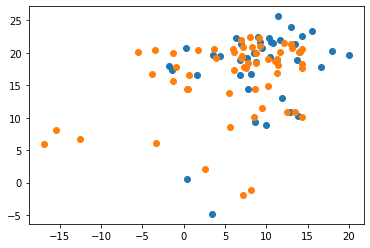

In [417]:
data = sciplex2[sciplex2.obs.index.isin(saha_sorted_index)].obsm['X_pca']
pl.scatter(data[:40,0], data[:40,1])
pl.scatter(data[400:,0], data[400:,1])

In [364]:
saha_costs = saha10_vs_dex10[0].sum(axis=1)
dex_costs = saha10_vs_dex10[0].sum(axis=0)

In [376]:
saha_sorted_idx = saha_costs.argsort()
saha_sorted_index = is_saha10[is_saha10 == True].index[saha_sorted_idx]

A01_A01_RT_384    False
A01_A01_RT_389    False
A01_A01_RT_390    False
A01_A01_RT_396    False
A01_A01_RT_397    False
                  ...  
H12_B02_RT_752    False
H12_B02_RT_753    False
H12_B02_RT_760    False
H12_B02_RT_761    False
H12_B02_RT_763    False
Length: 24189, dtype: bool

In [412]:
dex_sorted_idx = dex_costs.argsort()
dex_sorted_index = is_dex10[is_dex10 == True].index[dex_sorted_idx]

In [372]:
saha_sorted_idx.shape

(459,)

In [366]:
sciplex2.obs['transport_cost'] = 0.0

In [373]:
sciplex2.obs.index[saha_sorted_idx]

Index(['A02_B02_RT_543', 'A02_B02_RT_546', 'A01_B02_RT_535', 'A02_B02_RT_516',
       'A02_A01_RT_505', 'A01_B02_RT_496', 'A01_A01_RT_762', 'A02_A01_RT_754',
       'A02_B02_RT_630', 'A01_B02_RT_661',
       ...
       'A01_B02_RT_447', 'A02_B02_RT_449', 'A01_B02_RT_551', 'A01_B02_RT_683',
       'A01_B02_RT_514', 'A01_A01_RT_403', 'A01_A01_RT_449', 'A02_A01_RT_683',
       'A01_B02_RT_700', 'A02_A01_RT_397'],
      dtype='object', length=459)

In [375]:
is_saha10[is_saha10 == True].index[saha_sorted_idx]

Index(['G08_B02_RT_606', 'G09_A01_RT_635', 'C07_B02_RT_424', 'G05_A01_RT_710',
       'E07_A01_RT_449', 'C04_B02_RT_509', 'B08_B02_RT_476', 'F09_A01_RT_617',
       'G12_A01_RT_619', 'D04_A01_RT_425',
       ...
       'C01_A01_RT_466', 'G01_B02_RT_706', 'C09_A01_RT_637', 'D06_A01_RT_577',
       'C05_B02_RT_749', 'A03_A01_RT_746', 'A06_A01_RT_675', 'F05_A01_RT_541',
       'D07_B02_RT_545', 'E01_B02_RT_510'],
      dtype='object', length=459)

In [411]:
is_saha10 = (sciplex2.obs['treatment'] == 'SAHA') & (sciplex2.obs['dose'] == 10.0)
is_dex10 = (sciplex2.obs['treatment'] == 'Dex') & (sciplex2.obs['dose'] == 10.0)

In [398]:
sciplex2.obs['transport_cost_grouping'] = 'unknown'

for i in range(10):
    sciplex2.obs.loc[saha_sorted_index[(len(saha_sorted_index)//10) * (i):(len(saha_sorted_index)//10) * (i+1)] ,'transport_cost_grouping'] = f'{(i + 1) * 10} th percentile'

In [399]:
sciplex2.obs['transport_cost_grouping']

A01_A01_RT_384             unknown
A01_A01_RT_389             unknown
A01_A01_RT_390             unknown
A01_A01_RT_396             unknown
A01_A01_RT_397             unknown
                        ...       
H12_B02_RT_752             unknown
H12_B02_RT_753             unknown
H12_B02_RT_760             unknown
H12_B02_RT_761    20 th percentile
H12_B02_RT_763             unknown
Name: transport_cost_grouping, Length: 24189, dtype: object

/home/yavuz/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/yavuz/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'transport_cost_grouping' as categorical


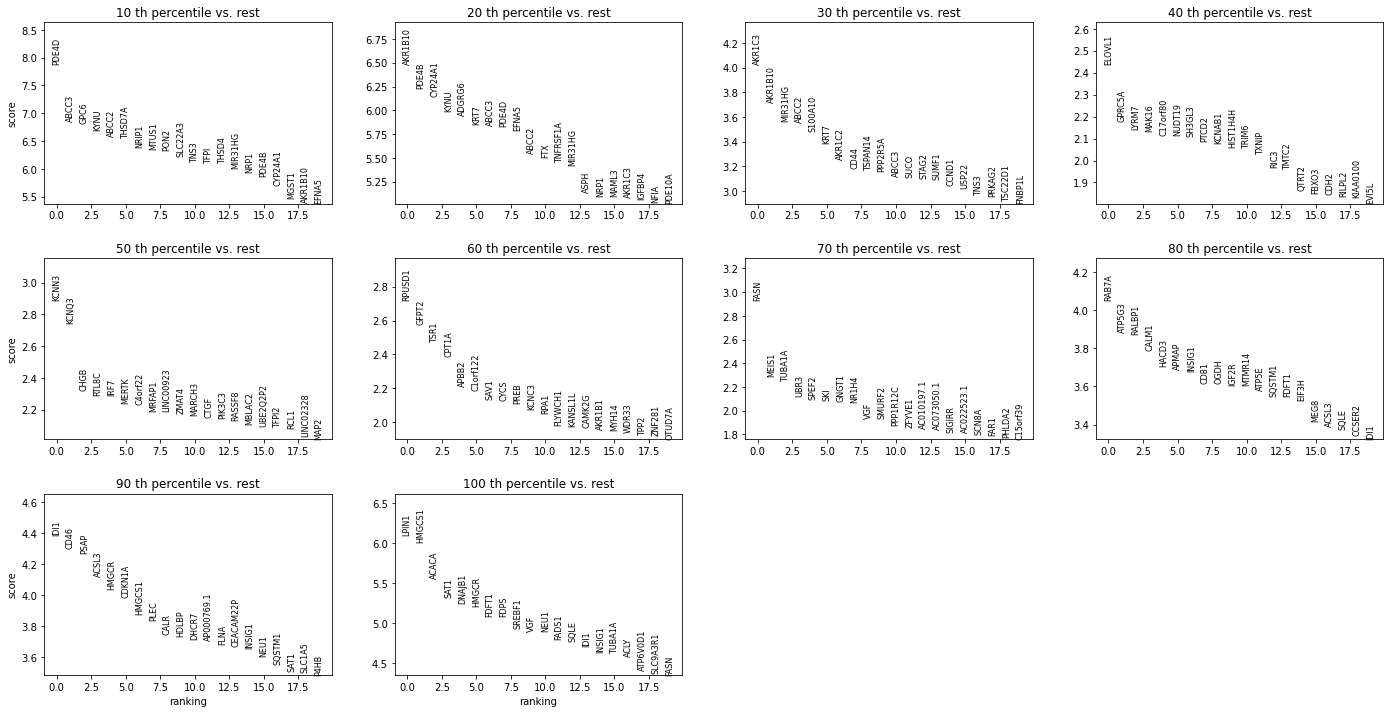

In [403]:
list_ = sciplex2[sciplex2.obs['transport_cost_grouping'] != 'unknown']
sc.tl.rank_genes_groups(list_, 'transport_cost_grouping', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(list_, n_genes=20, sharey=False, key='wilcoxon')

In [405]:
sciplex2.obs['transport_cost_grouping2'] = 'unknown'

for i in [0,9]:
    sciplex2.obs.loc[saha_sorted_index[(len(saha_sorted_index)//10) * (i):(len(saha_sorted_index)//10) * (i+1)] ,'transport_cost_grouping2'] = f'{(i + 1) * 10} th percentile'

/home/yavuz/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/yavuz/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'transport_cost_grouping' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'transport_cost_grouping2' as categorical


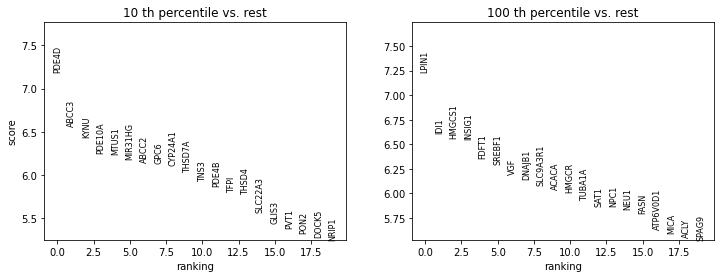

In [406]:
list_ = sciplex2[sciplex2.obs['transport_cost_grouping2'] != 'unknown']
sc.tl.rank_genes_groups(list_, 'transport_cost_grouping2', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(list_, n_genes=20, sharey=False, key='wilcoxon')

In [413]:
sciplex2.obs['transport_cost_grouping3'] = 'unknown'

i = 0
sciplex2.obs.loc[saha_sorted_index[(len(saha_sorted_index)//10) * (i):(len(saha_sorted_index)//10) * (i+1)] ,'transport_cost_grouping3'] = f'SAHA {(i + 1) * 10} th percentile'
sciplex2.obs.loc[dex_sorted_index[(len(dex_sorted_index)//10) * (i):(len(dex_sorted_index)//10) * (i+1)] ,'transport_cost_grouping3'] = f'Dex {(i + 1) * 10} th percentile'

/home/yavuz/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/yavuz/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'transport_cost_grouping' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'transport_cost_grouping2' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'transport_cost_grouping3' as categorical


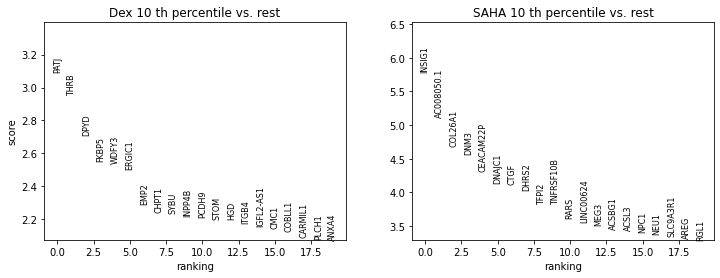

In [414]:
list_ = sciplex2[sciplex2.obs['transport_cost_grouping3'] != 'unknown']
sc.tl.rank_genes_groups(list_, 'transport_cost_grouping3', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(list_, n_genes=20, sharey=False, key='wilcoxon')

/home/yavuz/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'transport_cost_grouping' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'transport_cost_grouping2' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'transport_cost_grouping3' as categorical


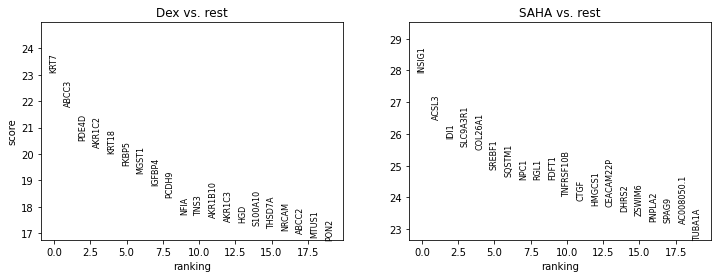

In [418]:
list_ = sciplex2[(is_saha10) | (is_dex10)]

sc.tl.rank_genes_groups(list_, 'treatment', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(list_, n_genes=20, sharey=False, key='wilcoxon')